<a href="https://colab.research.google.com/github/Aviva-Chen/bertForClassification_/blob/main/bertForSequenceCla_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
path='/content/gdrive/MyDrive/bertFolder'
os.chdir(path)
print(os.getcwd())

Mounted at /content/gdrive
/content/gdrive/MyDrive/bertFolder


In [ ]:
!pip3 install torchvision
!pip install transformers
!pip install datasets

In [ ]:
import pandas as pd
from sklearn.utils import shuffle
from datasets import Dataset

x_train=[]
y_train=[]

df = pd.read_excel("/content/gdrive/MyDrive/bertFolder/smallDataset.xlsx", names=['title', 'label'])
#df=df[:25000].append(df[175000:200000])
df1 = shuffle(df)

train_data0=list(df1['title'])
y_train=list(df1['label'])
y_train=[int(i) for i in y_train]
for title in train_data0:
    x_train.append(str(title))
df1 = pd.DataFrame({'label':y_train,'text':x_train})

test_df=pd.read_excel('/content/gdrive/MyDrive/bertFolder/testSet.xlsx',sheet_name='Sheet3',names=['title given by machine','label'])
x=list(test_df['title given by machine'])

x_test=[str(i) for i in x]
y_test=list(test_df['label'])
df2 = pd.DataFrame({'label':y_test,'text':x_test})

In [ ]:
from datasets import Dataset

#dataset1 = Dataset.from_pandas(df1[:48000])
#dataset2 = Dataset.from_pandas(df1[48000:])

dataset1 = Dataset.from_pandas(df1)
#dataset2 = Dataset.from_pandas(df2)

from transformers import Trainer,TrainingArguments,BertTokenizer,BertForSequenceClassification,AutoTokenizer,AutoModelForSequenceClassification

#model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

#tokenizer =AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True,max_length=32, truncation=True)

tokenized_datasets1 = dataset1.map(tokenize_function, batched=True)
#tokenized_datasets2 = dataset2.map(tokenize_function, batched=True)
dataset3 = Dataset.from_pandas(df2)
tokenized_datasets3 = dataset3.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="/content/gdrive/MyDrive/bertFolder/logs_constant"

In [ ]:
training_args = TrainingArguments(
    output_dir='./results', #存储结果文件的目录
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32, 
    learning_rate=3e-5, 
    lr_scheduler_type='constant',
    weight_decay=0.01,
    warmup_steps=100,
    evaluation_strategy="steps", #这里设置每100个batch做一次评估，也可以为“epoch”，也就是每个epoch进行一次
    eval_steps=10,
    logging_strategy = "steps",
    save_strategy ='no',
    logging_steps = 10,
    seed = 2022,
    logging_dir='./logs_constant', #存储logs的目录
    report_to='tensorboard'
)

from datasets import load_metric
import numpy as np
def compute_metrics(eval_preds):
    metric = load_metric("glue", "mrpc")
    logits, labels = eval_preds.predictions, eval_preds.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_datasets1,
    eval_dataset=tokenized_datasets3,
    tokenizer = tokenizer
)

In [ ]:
trainer.train()

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_datasets1,
    eval_dataset=tokenized_datasets3,
    tokenizer = tokenizer
)
trainer.evaluate()

In [ ]:
import os,torch
os.chdir('/content/gdrive/MyDrive/bertFolder')

#保存模型
torch.save(model,'/content/gdrive/MyDrive/bertFolder/Model8.pt')

In [ ]:
import torch
model = torch.load("/content/gdrive/MyDrive/bertFolder/model1.pt",map_location=torch.device('cpu'))

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#测试集性能
import pandas as pd
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split, RandomSampler, SequentialSampler
import numpy as np

test_df=pd.read_excel('/content/gdrive/MyDrive/bertFolder/testSet.xlsx',sheet_name='Sheet3',names=['title given by machine','label'])
test_data0=list(test_df['title given by machine'])

sentences=[str(i) for i in test_data0]
labels=list(test_df['label'])

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    print(sent)
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=32,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(torch.device("cpu")) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report

flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

print(classification_report(flat_predictions,flat_true_labels,digits=3))
mcc= matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: %.3f' % mcc)

In [ ]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import warnings
from sklearn.svm import SVC
from sklearn.manifold import TSNE

warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')  # 忽略警告

# print("100维没有其他操作")

#训练数据
x_train=[]
y_train=[]

df1= pd.read_excel("/content/gdrive/MyDrive/bertFolder/wholeDataset.xlsx",names=['title','label'])
print('finish loading')
df1=df1[:50000].append(df1[130000:180000])
train_data0=list(df1['title'])
for title in train_data0:
    x_train.append(str(title))
y_train=list(df1['label'])

test_df = pd.read_excel('/content/gdrive/MyDrive/bertFolder/testSet.xlsx', sheet_name='Sheet3',names=['title given by machine','label'])
x_test = list(test_df['title given by machine'])
y_test0=list(test_df['label'])
y_test=[str(i) for i in y_test0]


#得到全部的输入模型的文字:处理包括转成字符串+切片+小写 格式：列表的列表
sentences = []
x_alls = x_train+x_test
for x_all in x_alls:
    x_all = str(x_all)
    x_all = x_all.lower()
    x_all_split = x_all.split()
    sentences.append(x_all_split)

print("sentences完成")

model= Word2Vec(sentences,size=100)

print("模型建立完成")

#保存模型
model.save('/content/gdrive/MyDrive/bertFolder/word2vec.w2v')
model.wv.save_word2vec_format('/content/gdrive/MyDrive/bertFolder/word2vec.bin',binary=False)
model_ = model.wv.load_word2vec_format('/content/gdrive/MyDrive/bertFolder/word2vec.bin',binary=False)
#获得句子的向量
def get_sentence_vec(sentence):
    w2v_sum = []
    total = 0
    for word in sentence:
        try:
            w2v_tmp = model_[word]
            #print(w2v_tmp)
            total = total + 1
            if len(w2v_sum) > 0:
                w2v_sum = list(np.array(w2v_tmp) + np.array(w2v_sum))
            else:
                w2v_sum = list(np.array(w2v_tmp))
        except Exception as e:
            pass

    if len(w2v_sum) == 100:
        w2v_documents = [float("{:.6f}".format(w2v / total)) for w2v in w2v_sum]
        return w2v_documents
    else:
        return []

#计算特征值
x_train_vec = []
x_test_vec = []
x_train_sentences = []
x_test_sentences = []

for x_train_item in x_train:
    x_train_item = str(x_train_item)
    x_train_item = x_train_item.lower()
    x_train_item_split = x_train_item.split()
    x_train_sentences.append(x_train_item_split)

for x_test_item in x_test:
    x_test_item = str(x_test_item)
    x_test_item = x_test_item.lower()
    x_test_item_split = x_test_item.split()
    x_test_sentences.append(x_test_item_split)

kongde1 = []
kongde2 = []

for i in range(len(x_train_sentences)):
    vec = get_sentence_vec(x_train_sentences[i])
    if vec:
        x_train_vec.append(vec)
    else:
        kongde1.append(i)

for i in range(len(x_test_sentences)):
    vec = get_sentence_vec(x_test_sentences[i])
    if vec:
        x_test_vec.append(vec)
    else:
        kongde2.append(i)

kongde1 = sorted(kongde1,reverse=True)
for kongde11 in kongde1:
    del y_train[kongde11]

kongde2 = sorted(kongde2,reverse=True)
for kongde22 in kongde2:
    del y_test[kongde22]

print("开始svm")

def train_svm(x_train_vec, y_train):
    # C惩罚系数
    clf = SVC(C=1, kernel='rbf',  decision_function_shape='ovr')
    clf.fit(x_train_vec, y_train)
    # 封装模型
    print('保存模型...')
    joblib.dump(clf, 'svm_sig100.pkl')
    return clf

#模型评估
import joblib
from sklearn.metrics import classification_report,matthews_corrcoef

clf=train_svm(x_train_vec,y_train)
svm = joblib.load('svm_sig100.pkl')
y_pred = svm.predict(x_test_vec)

finish loading
sentences完成
模型建立完成
开始svm
保存模型...


In [ ]:
test_df = pd.read_excel('/content/gdrive/MyDrive/bertFolder/testSet.xlsx', sheet_name='Sheet3',names=['title given by machine','label'])
x_test = list(test_df['title given by machine'])
y_test0=list(test_df['label'])
y_test=[int(i) for i in y_test0]

kongde2 = []


for i in range(len(x_test_sentences)):
    vec = get_sentence_vec(x_test_sentences[i])
    if vec:
        x_test_vec.append(vec)
    else:
        kongde2.append(i)


kongde2 = sorted(kongde2,reverse=True)
for kongde22 in kongde2:
    del y_test[kongde22]

In [ ]:
print(y_pred)
print(y_test)

[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 

In [ ]:
true_label=[int(i) for i in flat_true_labels]
predictions=[int(i) for i in flat_predictions]
print(true_label)
print(predictions)

[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 

In [ ]:
print(classification_report(y_test, y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.761     0.675     0.716       419
           1      0.779     0.843     0.810       568

    accuracy                          0.772       987
   macro avg      0.770     0.759     0.763       987
weighted avg      0.771     0.772     0.770       987



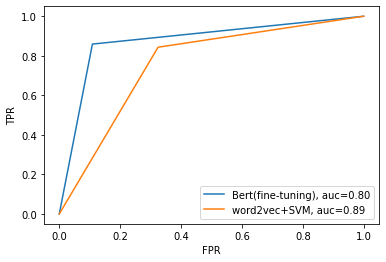

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
 
plt.figure(0).clf()  # plt.close()将完全关闭图形窗口，其中plt.clf()将清除图形-您仍然可以在其上绘制另一个绘图。
 
label = np.random.randint(2, size=1000)
 
fpr, tpr, thresh = metrics.roc_curve(flat_true_labels, flat_predictions)
 
auc =0.80
plt.plot(fpr, tpr, label="Bert(fine-tuning), auc=" + "0.80")

fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)
auc = 0.89
plt.plot(fpr, tpr, label="word2vec+SVM, auc=" + str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend(loc=0)  # 说明所在位置
plt.show()